### Foreword

This notebook is based on the provided example notebook from the CICIoT2023 dataset. Various improvements have been made such as actual random testing data, possibility to set random seeds, addition of undersampling+SMOTE preprocessing, more ML models and better performance metrics information.

# Introduction
The aim of the project was to find a information and communication technology related dataset to analyse using available machine learning tools. In that scope, a dataset related to malicious attacks on IoT devices were chosen. The aim is to study the feasibility of using ML as additional layer of security in network based attack detection.

The data was analysed using well-known ML and data analysis modules such as pandas, numpy, scikit-learn and pytorch. This report will describe the used dataset, as well as performance and characteristics regarding the used models and methods from the abovementioned modules.


# Dataset analysis
## Data gathering
The dataset analysis was performed in the preliminary report. The data contains several features of packets captured during a controlled attack with various methods on a setup IoT environment. The obtained packet capture files were transformed into .csv format describing flow features chosen by the people who obtained this data. The high level topology diagram is shown below:

![CICIoT2023 testbed diagram](images/cic-diagram3-2023.jpg)


## Feature description
The extracted features correspond to flows extracted from the packet captures. They are:
- Ts – timestamp of the packet.
- Flow duration – packet travel time.
- Protocol type – defines transport or network layer protocol information.
- Duration – packet TTL.
- Rate, srate and drate – respectively: general rate of packet transmission in a flow, outbound rate, and inbound rate.
- FIN/SYN/RST/PSH/ACK/ECE/CWR flag number – (Boolean) values indicating status of TCP flags in the packet.
- ACK/SYN/FIN/URG/RST count – number of packets with these flags set in the same flow. These flags are important in the context of TCP and TCP-related attacks.
- HTTP/HTTPS/DNS/Telnet/SMTP/SSH/IRC/DHCP – (Boolean) values indicating presence of application layer protocols.
- TCP/UDP – (Boolean) values indicating presence of transport layer protocols.
- ICMP/IPv – like above but for network layer.
- ARP/LLC – like above but for link layer.
- Tot sum, min, max, avg, std – respectively the sum, minimum, maximum, average, standard deviation of packet lengths in a flow.
- Tot size – length of a single packet.
- IAT – time delta with the previous packet.
- Number – count of packets in a flow.

For the below values, where:
- $l_i$: length of ingress packets in flow.
- $l_o$: length of egress packets in flow.

1. **Magnitude:**
   - $\text{Magnitude} = \sqrt{\overline{l_i} + \overline{l_o}}$

2. **Radius:**
   - $\text{Radius} = \sqrt{{\text{Var}(l_i)}^2 + {\text{Var}(l_o)}^2}$
   - (where $\text{Var}(x)$ represents the variance of $x$)

3. **Covariance:**
   - $\text{Covariance} = \text{Cov}(l_i,l_o)$

4. **Variance:**
   - $\text{Variance} = \frac{{l_i}^2}{{l_o}^2}$

5. **Weight:**
   - $\text{Weight} = \text{count\_ingress} \times \text{count\_egress}$

Since there are a lot of features, feature selection could be a good idea to remove unimportant features. This is described in detail later.

Below is shown the definition of X_column labels in Python


In [30]:
X_columns = [
    'flow_duration', 'Header_Length', 'Protocol Type', 'Duration',
       'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count',
       'syn_count', 'fin_count', 'urg_count', 'rst_count', 
    'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP',
       'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min',
       'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue',
       'Radius', 'Covariance', 'Variance', 'Weight', 
]
y_column = 'label'

## Label description
The labels are different attack types that the packet metrics correspond to. This is the full list of labels:
- DDoS – Distributed Denial of Service
  - ICMP Flood
  - ICMP Fragmentation
  - UDP Flood
  - UDP Fragmentation
  - TCP Flood
  - PSHACK Flood
  - ACK Fragmentation
  - SYN Flood
  - RSTFIN Flood
  - SynonymousIP Flood
  - HTTP Flood
  - Slow Loris
- DoS – Denial of Service
  - UDP Flood
  - TCP Flood
  - SYN Flood
  - HTTP Flood
- Benign traffic
- Mirai – IoT Botnet
  - GRE Flood
  - UDP Plain
  - GREIP Flood
- Spoofing
  - ARP
  - DNS
- Recon – Reconnaissance
  - OS Scan
  - Port Scan
  - Vulnerability Scan
  - Ping Sweep
- Dictionary Bruteforce
- Web
  - Browser Hijacking
  - Command Injection
  - SQL Injection
  - XSS
  - Backdoor Malware
  - Uploading Attack

There are in total 34 labels that can be reduced to 8 labels based on the main type or even down to 2 classes to do a binary classification whether the packet is malicious or benign. For the 8 or 2 label scenario, a different neural network or system could be trained to determine the exact attack type. However, in case of security the binary classification can be sufficient to prevent malicious traffic.


## Class distribution and imbalance reduction
The class distribution of the whole dataset is shown below:

![Class distribution](images/inline-bar-graphjpg.jpg)

As it can be seen, the dataset is significantly imbalanced towards the DDoS and DoS packets. This can be an issue for some of the machine learning algorithms. Despite the nature of DDoS and DoS being flooding, thus causing the imbalance, it was chosen to apply SMOTE + under-sampling technique for the sampling data. 

First, under-sampling will remove excessive DDoS and DoS data. The counts will match the benign packet counts. Then, SMOTE will create artificial samples for the minority classes to match the earlier under-sampled counts. That way the label counts will be balanced. This mechanism is implemented in the main loop mechanism and the logic to realise it is explained in inline comments.

For dataset parts that do not have enough samples (6) in the minority classes to apply SMOTE, random oversampling will be first applied to these classes to make them valid for SMOTE. Skipping these datasets would cause different dataset parts to be used in non-preprocessing notebook despite seed being the same. This would cause incorrect comparison.

# Machine learning algorithm evaluation
With the dataset, an already provided Jupyter notebook allows to evaluate any scikit-learn machine learning algorithm with comparison to others. However, by default only linear regression is trained and there are a lot of features missing. As mentioned in the foreword, this notebook was expanded with "random testing data, possibility to set random seeds, addition of undersampling+SMOTE preprocessing, more ML models and better performance metrics information \[Weighted scores, confusion matrices\].".

## Scenarios & algorithms
3 label scenarios are analyzed:
- 34 Classes classification
- 8 Classes, remapped by the main type
- 2 Classes, benign or attack

And the following ML algorithms were used and evaluated:
- Logistic Regression – the most basic statistical method for classification that models the probability. It is usually used for binary classification where the sigmoid function is used to map the input features to a probability value. However, for multiclass classification softmax function is used to determine probability of a sample belonging to each class, then choosing the highest probability. 
- Decision Tree – A non-parametric model that splits the data into subsets depending on the input features. It uses the tree analogy where each node represents a feature, each branch a decision rule, and each leaf at the end represents a class. 
- Random Forest – Consists of multiple decision trees with aim to improve model’s accuracy and robustness. Each tree is trained on different data. The decision is made by reading the average or majority voting across the trees. 
- Gradient Boost (eXtra Gradient Boosting) – is a relatively new gradient boosting implementation.  
- Neural Network – A model with structure similar to the human brain. Consists of interconnected layers of nodes (neurons). Each connection has a weight which is adjusted based on the backpropagation to minimize error. 

Furthermore, other algorithms were analysed e.g. SGD, kneighbors and ANN (pytorch), but are not included due to bad results. The ANN implementation is also provided as a jupyter notebook [(neural_pytorch.ipynb)](./neural_pytorch.ipynb), but it is not heavily considered. The best F1 score after applying various preprocessing, weighting and trying different NN architectures was 0.7 for 7 classes, which is bad compared to the results for classical ML algorithms. This is possible - in various kaggle datasets ANN performed worse than e.g. eXtra Gradient Boosting.

## Evaluation
The evaluation is performed based on the typical machine learning metrics, namely accuracy, precision, recall and most importantly f1 score. The accuracy in case of the imbalanced CICIoT2023 set is a bad metric, but it is also required to handle well both false positives and false negatives. In real-life scenario both blocking legitimate network traffic and allowing malicious traffic should not occur. The discussed metrics are defined as follows: 

The precision, recall and f1 are both analysed in weighted and macro mode. In macro mode, the precision, recall and f1 are averaged over each class equally, where in weighted mode the specific class metrics are multiplied by the weight, meaning that mistakes for smaller labels are considered less compared to main labels. This approach can be better, since the analysed dataset is imbalanced, but in that scenario it allows for bigger leniency towards more refined attacks and benign packets that are in the minority. This is not a fully correct approach, hence in the end mainly the macro metric is considered.

The abovementioned features are analysed for all the enumerated ML models for two scenarios. First is when there was no preprocessing applied, and 2nd where a special preprocessing pipeline was applied to undersample the majority labels and then SMOTE for the minority class. This notebook presents the more advanced version with undersampling+SMOTE. Result comparison is at the end of the notebook, with data copied from the other notebook.

# Code
Below written is the code for the SMOTE + undersampling scenario, based on the provided CICIoT2023 example

In [31]:
import pandas as pd
import numpy as np
import os
from tqdm.notebook import tqdm
import warnings
import random
SEED = 42  # Set to None for randomness
if SEED:
    random.seed(SEED)
    print(f"INFO: Using seed {SEED}")
else:
    print(f"Using random seed")

# Manual train/test splitting
warnings.filterwarnings('ignore')

INFO: Using seed 42


In [32]:
DATASET_DIRECTORY = '../CICIoT2023/'

### Determining train/test dataset parts
The df_sets is the list of all the dataset .csv parts
The test and train indexing counts are split 80%/20% and then divided by 4 to use only 1/4 of the dataset
Then test indexes are chosen randomly, and based on these choices train indexes are chosen from the start of all indexes as long as they are not in test indexes already

In [33]:
df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
df_sets.sort()
test_indexes_count = int(len(df_sets)*0.2)//4
train_indexes_count = int(len(df_sets)*0.8)//4
index_range = range(len(df_sets))
test_indexes = random.sample(index_range, test_indexes_count)
train_indexes = [i for i in index_range if i not in test_indexes][:train_indexes_count]
training_sets, test_sets = [], []
for i in train_indexes:
    training_sets.append(df_sets[i])
for i in test_indexes:
    test_sets.append(df_sets[i])

### Scaling
Simple declaration of a scaler that will be used later

In [34]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

### Preprocessing dependencies
The preprocessing pipeline is defined later during the loop as it requires parameters depending on the current processed dataset part

In [35]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


### Classification: 34 (33+1) classes
All models are defined in accordance with the information earlier.

### The main loop
The main training loop works as follows:
- Current .csv part is read
- Counter is used to count the labels for the current part
- Based on the label counts the benign label count is determined as well as label names which have less than minimum required to perform SMOTE
- The resampling pipeline is defined and used. The 3 parts are:
  - Random Oversampling is used for the earlier determined labels which have less than minimum samples for SMOTE
  - Labels with counts higher than benign are undersampled to match benign class counts
  - SMOTE is used to generate samples for minority classes to match the benign class counts
- X is scaled
- Each model is trained with the data. Note: for eXtra Gradient Boosting additonal step before that is to encode labels

For information, data length before and after the pipeline is also printed

In [36]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import f1_score
from collections import Counter

ML_models = [ # or 'rbf', 'poly' for different kernels
        LogisticRegression(),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        xgb.XGBClassifier(
            eval_metric=f1_score,
            random_state=SEED,
            device='cuda'
        )
        
]
ML_neams = [
        'LogisticRegresion',
        'Decision Tree',
        'Random Forest',
        'eXtreme Gradient Boosting'
]

label_encoder = LabelEncoder()
for train_set in tqdm(training_sets):
    d = pd.read_csv(DATASET_DIRECTORY + train_set)
    # Undersample until there are no classes which have more samples than benign, and then apply SMOTE
    label_counts = Counter(d[y_column]).most_common()
    old_len = len(d[y_column])
    benign_index = next((i for i, l in enumerate(label_counts) if l[0] == 'BenignTraffic'))
    less_than_six_labels = [l[0] for i, l in enumerate(label_counts) if l[1] <= 5]
    resampling_pipeline = Pipeline([
        ('over', RandomOverSampler(sampling_strategy={l: 6 for l in less_than_six_labels}, random_state=42)),
        ('under', RandomUnderSampler(sampling_strategy={l[0]: label_counts[benign_index][1] for l in label_counts[:benign_index]}, random_state=42)),
        ('SMOTE', SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5))
    ])
    X, y = resampling_pipeline.fit_resample(d[X_columns], d[y_column])
    new_len = len(y)
    print(f"Old len: {old_len}; New len: {new_len}")
    del d
    X = scaler.fit_transform(X)
    for i, model in enumerate(ML_models):
        if i == len(ML_models)-1:
            y = label_encoder.fit_transform(y)
        model.fit(X, y)

  0%|          | 0/33 [00:00<?, ?it/s]

Old len: 238687; New len: 190400
Old len: 218805; New len: 176800
Old len: 275258; New len: 217158
Old len: 231023; New len: 180098
Old len: 227491; New len: 183124
Old len: 240046; New len: 196758
Old len: 227910; New len: 181118
Old len: 246327; New len: 199716
Old len: 227616; New len: 185776
Old len: 251392; New len: 203728
Old len: 221928; New len: 177514
Old len: 238476; New len: 185980
Old len: 238761; New len: 193120
Old len: 215838; New len: 171564
Old len: 268649; New len: 218518
Old len: 232885; New len: 183600
Old len: 223444; New len: 176766
Old len: 234430; New len: 187578
Old len: 231063; New len: 183498
Old len: 237151; New len: 186592
Old len: 223401; New len: 177242
Old len: 252212; New len: 204952
Old len: 262062; New len: 214608
Old len: 225725; New len: 174862
Old len: 447625; New len: 357850
Old len: 221014; New len: 179894
Old len: 251676; New len: 206074
Old len: 238350; New len: 195058
Old len: 228730; New len: 181730
Old len: 227636; New len: 185198
Old len: 4

### Testing - 34 classes
For testing the loop logic is the following:
- A single dataset is read from the test set
- The X_column is scaled
- The y labels are saved in an array for later checking (y_test)
- Then for each model the predictions are made
- For eXtra Gradient Boosting, label decoding is performed
- Predictions are written to a dictionary (preds)where each key corresponds to a model and the value are the predictions

In [37]:
y_test = []
preds = {i:[] for i in range(len(ML_models))}
for test_set in tqdm(test_sets):
    d_test = pd.read_csv(DATASET_DIRECTORY + test_set)
    d_test[X_columns] = scaler.transform(d_test[X_columns])
    
    y_test += list(d_test[y_column].values)
    
    for i in range(len(ML_models)):
        model = ML_models[i]
        y_pred = list(model.predict(d_test[X_columns]))
        if i == len(ML_models)-1:
            y_pred = list(label_encoder.inverse_transform(model.predict(d_test[X_columns])))
        preds[i] = preds[i] + y_pred
        

  0%|          | 0/8 [00:00<?, ?it/s]

### Evaluation - 34 classes
Evalation is done based on the earlier gathered y_test and preds data
- Preds dictionary is iterated on, getting current model number and it's predictions
- Metrics are calculated: accuracy, recall, precision, f1 for macro, then for weighted
- Confusion matrix and class names are determined. For eXtra Gradient Boosting the class names are decoded from the label encoder
- The confusion matrix is saved in .csv format

The data is in a raw "csv-like" format, hence later on it's postprocessed and put into tables in the final comparison

In [38]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
print("### 34 CLASSES; PREPROCESSED ###")
print("Model;accuracy;recall;precision;f1")
for k,v in preds.items():
    y_pred = v
    print(f"MACRO;{ML_neams[k]};{accuracy_score(y_pred, y_test)};{recall_score(y_pred, y_test, average='macro')};{precision_score(y_pred, y_test, average='macro')};{f1_score(y_pred, y_test, average='macro')}")
    print(f"WEIGHTED;{ML_neams[k]};{accuracy_score(y_pred, y_test)};{recall_score(y_pred, y_test, average='weighted')};{precision_score(y_pred, y_test, average='weighted')};{f1_score(y_pred, y_test, average='weighted')}")
    cm = confusion_matrix(y_test, y_pred)
    cn = ML_models[k].classes_
    if ML_neams[k] == ML_neams[-1]:
        cn = label_encoder.inverse_transform(ML_models[k].classes_)
    
    # plt.figure(figsize=(12, 9))
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cn, yticklabels=cn)
    # plt.xlabel('Predicted')
    # plt.ylabel('Actual')
    # plt.title('Confusion Matrix')
    # plt.savefig('confusion_matrix_seaborn.png', dpi=500, bbox_inches='tight')
    # plt.show()
    
    # Convert confusion matrix array to a DataFrame
    cm_df = pd.DataFrame(cm, index=cn, columns=cn)
    
    # Export the DataFrame to a CSV file
    cm_df.to_csv(f'cms-42-preprocessing-FIXED/confusion_matrix-{ML_neams[k]}-34.csv')

print('\n\n')

### 34 CLASSES; PREPROCESSED ###
Model;accuracy;recall;precision;f1
MACRO;LogisticRegresion;0.7884417318163915;0.5053416133817586;0.5587953268888349;0.4962593299780211
WEIGHTED;LogisticRegresion;0.7884417318163915;0.7884417318163915;0.8281655089786302;0.7978128755900339
MACRO;Decision Tree;0.9906282321203489;0.7707543554198497;0.8310808016988763;0.7935389577519071
WEIGHTED;Decision Tree;0.9906282321203489;0.9906282321203489;0.9901397205382421;0.9902915720045438
MACRO;Random Forest;0.9907933180495249;0.7585832567260513;0.7671786273829867;0.7586294812795581
WEIGHTED;Random Forest;0.9907933180495249;0.9907933180495249;0.9910951189945001;0.9908266980778854
MACRO;eXtreme Gradient Boosting;0.9937522991790333;0.8346161419874272;0.827067672882944;0.8291148766932506
WEIGHTED;eXtreme Gradient Boosting;0.9937522991790333;0.9937522991790333;0.9939511875407464;0.9938178792892591




# Classification: 8 (7+1) classes
The steps are the same as for the 34 classes, but with the requirement of a dictionary that remaps the attack subtypes into their main types

In [39]:
if True:
    dict_7classes = {}
    dict_7classes['DDoS-RSTFINFlood'] = 'DDoS'
    dict_7classes['DDoS-PSHACK_Flood'] = 'DDoS'
    dict_7classes['DDoS-SYN_Flood'] = 'DDoS'
    dict_7classes['DDoS-UDP_Flood'] = 'DDoS'
    dict_7classes['DDoS-TCP_Flood'] = 'DDoS'
    dict_7classes['DDoS-ICMP_Flood'] = 'DDoS'
    dict_7classes['DDoS-SynonymousIP_Flood'] = 'DDoS'
    dict_7classes['DDoS-ACK_Fragmentation'] = 'DDoS'
    dict_7classes['DDoS-UDP_Fragmentation'] = 'DDoS'
    dict_7classes['DDoS-ICMP_Fragmentation'] = 'DDoS'
    dict_7classes['DDoS-SlowLoris'] = 'DDoS'
    dict_7classes['DDoS-HTTP_Flood'] = 'DDoS'
    
    dict_7classes['DoS-UDP_Flood'] = 'DoS'
    dict_7classes['DoS-SYN_Flood'] = 'DoS'
    dict_7classes['DoS-TCP_Flood'] = 'DoS'
    dict_7classes['DoS-HTTP_Flood'] = 'DoS'
    
    
    dict_7classes['Mirai-greeth_flood'] = 'Mirai'
    dict_7classes['Mirai-greip_flood'] = 'Mirai'
    dict_7classes['Mirai-udpplain'] = 'Mirai'
    
    dict_7classes['Recon-PingSweep'] = 'Recon'
    dict_7classes['Recon-OSScan'] = 'Recon'
    dict_7classes['Recon-PortScan'] = 'Recon'
    dict_7classes['VulnerabilityScan'] = 'Recon'
    dict_7classes['Recon-HostDiscovery'] = 'Recon'
    
    dict_7classes['DNS_Spoofing'] = 'Spoofing'
    dict_7classes['MITM-ArpSpoofing'] = 'Spoofing'
    
    dict_7classes['BenignTraffic'] = 'Benign'
    
    dict_7classes['BrowserHijacking'] = 'Web'
    dict_7classes['Backdoor_Malware'] = 'Web'
    dict_7classes['XSS'] = 'Web'
    dict_7classes['Uploading_Attack'] = 'Web'
    dict_7classes['SqlInjection'] = 'Web'
    dict_7classes['CommandInjection'] = 'Web'
    
    
    dict_7classes['DictionaryBruteForce'] = 'BruteForce'

### Training - 8 classes
The steps are the same as for 34 classes, with the only difference being the use of the remapping dictionary on the y labels before fitting them to the models

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

ML_models = [ # or 'rbf', 'poly' for different kernels
        LogisticRegression(),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        xgb.XGBClassifier(
            n_estimators=100,
            max_depth=10,
            learning_rate=0.1,
            random_state=SEED,
            device='cuda'
        ),
        
]

ML_neams = [
        'LogisticRegresion',
        'Decision Tree',
        'Random Forest',
        'eXtreme Gradient Boosting'
]
for train_set in tqdm(training_sets):
    d = pd.read_csv(DATASET_DIRECTORY + train_set)
    # Undersample until there are no classes which have more samples than benign, and then apply SMOTE
    label_counts = Counter(d[y_column]).most_common()
    old_len = len(d[y_column])
    benign_index = next((i for i, l in enumerate(label_counts) if l[0] == 'BenignTraffic'))
    less_than_six_labels = [l[0] for i, l in enumerate(label_counts) if l[1] <= 5]
    resampling_pipeline = Pipeline([
        ('over', RandomOverSampler(sampling_strategy={l: 6 for l in less_than_six_labels}, random_state=42)),
        ('under', RandomUnderSampler(sampling_strategy={l[0]: label_counts[benign_index][1] for l in label_counts[:benign_index]}, random_state=42)),
        ('SMOTE', SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5))
    ])
    X, y = resampling_pipeline.fit_resample(d[X_columns], d[y_column])
    new_len = len(y)
    print(f"Old len: {old_len}; New len: {new_len}")
    del d
    
    new_y = [dict_7classes[k] for k in y]
    y = new_y
    X = scaler.fit_transform(X)
    for i, model in enumerate(ML_models):
        if i == len(ML_models)-1:
            y = label_encoder.fit_transform(y)
        model.fit(X, y)
    


  0%|          | 0/33 [00:00<?, ?it/s]

Old len: 238687; New len: 190400
Old len: 218805; New len: 176800
Old len: 275258; New len: 217158
Old len: 231023; New len: 180098
Old len: 227491; New len: 183124
Old len: 240046; New len: 196758
Old len: 227910; New len: 181118
Old len: 246327; New len: 199716
Old len: 227616; New len: 185776
Old len: 251392; New len: 203728
Old len: 221928; New len: 177514
Old len: 238476; New len: 185980
Old len: 238761; New len: 193120
Old len: 215838; New len: 171564
Old len: 268649; New len: 218518
Old len: 232885; New len: 183600
Old len: 223444; New len: 176766
Old len: 234430; New len: 187578
Old len: 231063; New len: 183498
Old len: 237151; New len: 186592
Old len: 223401; New len: 177242
Old len: 252212; New len: 204952
Old len: 262062; New len: 214608
Old len: 225725; New len: 174862
Old len: 447625; New len: 357850
Old len: 221014; New len: 179894
Old len: 251676; New len: 206074
Old len: 238350; New len: 195058
Old len: 228730; New len: 181730
Old len: 227636; New len: 185198
Old len: 4

### Evaluation - 8 classes
Same as for evaluation for 34 classes, but also with the use of the remapping dictionary

In [41]:
y_test = []
preds = {i:[] for i in range(len(ML_models))}
for test_set in tqdm(test_sets):
    d_test = pd.read_csv(DATASET_DIRECTORY + test_set)
    d_test[X_columns] = scaler.transform(d_test[X_columns])
    new_y = [dict_7classes[k] for k in d_test[y_column]]
    d_test[y_column] = new_y
    
    y_test += list(d_test[y_column].values)
    
    for i in range(len(ML_models)):
        model = ML_models[i]
        y_pred = list(model.predict(d_test[X_columns]))
        if i == len(ML_models)-1:
            y_pred = list(label_encoder.inverse_transform(model.predict(d_test[X_columns])))
        preds[i] = preds[i] + y_pred
        

  0%|          | 0/8 [00:00<?, ?it/s]

### Evaluation - 8 classes
The evaluation is also the same as for 34 classes, but this time the confusion matrix is also written out in graphical form rather than just being written to .csv
This is done using matplotlib and seaborn heatmap. This allows to visualise where a given model makes mistakes.


### 8 CLASSES; PREPROCESSED ###
Model;accuracy;recall;precision;f1
MACRO;LogisticRegresion;0.8090740065921714;0.5610199331460768;0.5447892110015741;0.48978474278490797
WEIGHTED;LogisticRegresion;0.8090740065921714;0.8090740065921714;0.8927992734559138;0.8371007775021396


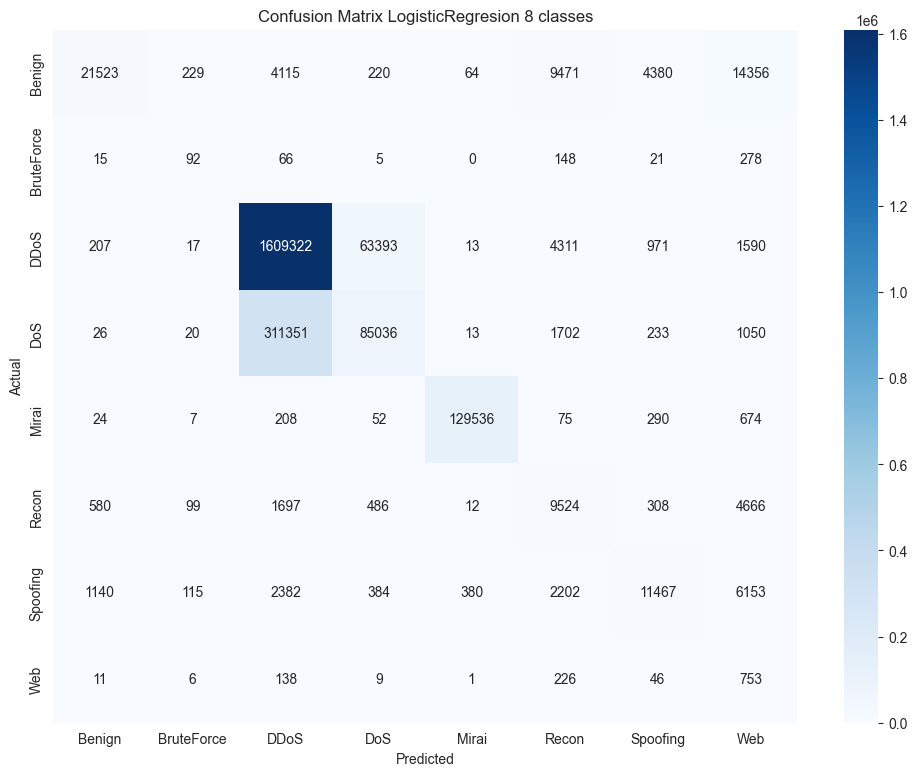

MACRO;Decision Tree;0.99352395197516;0.7799060913080424;0.8396553358258417;0.8031197244887542
WEIGHTED;Decision Tree;0.99352395197516;0.99352395197516;0.9933354338765856;0.9933698856034195


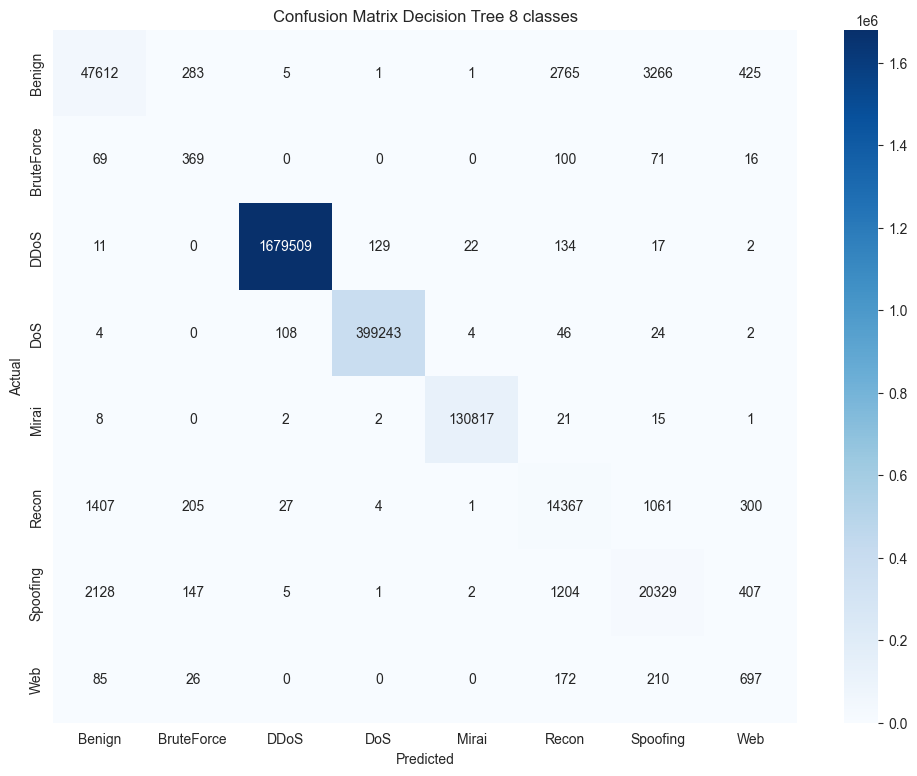

MACRO;Random Forest;0.9941769296530293;0.8186644483527392;0.7797223029654464;0.7837074271870841
WEIGHTED;Random Forest;0.9941769296530293;0.9941769296530293;0.9941868370476035;0.9941414102441176


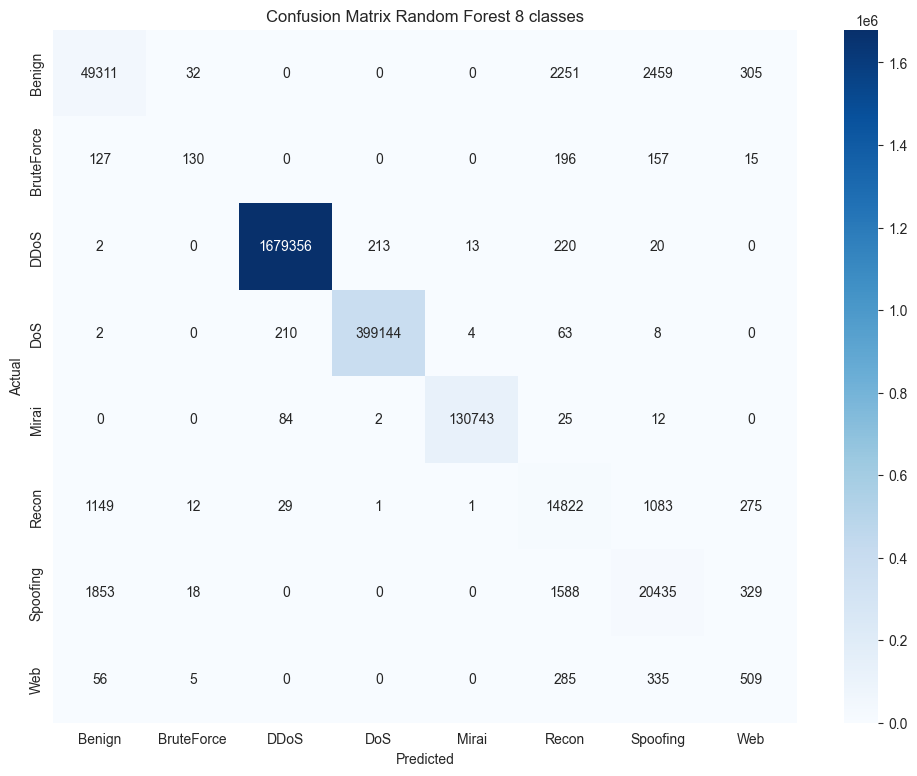

MACRO;eXtreme Gradient Boosting;0.9950617209059881;0.8386027407627153;0.8469660615089296;0.8339957458719612
WEIGHTED;eXtreme Gradient Boosting;0.9950617209059881;0.9950617209059881;0.9949788408545426;0.9949571397333996


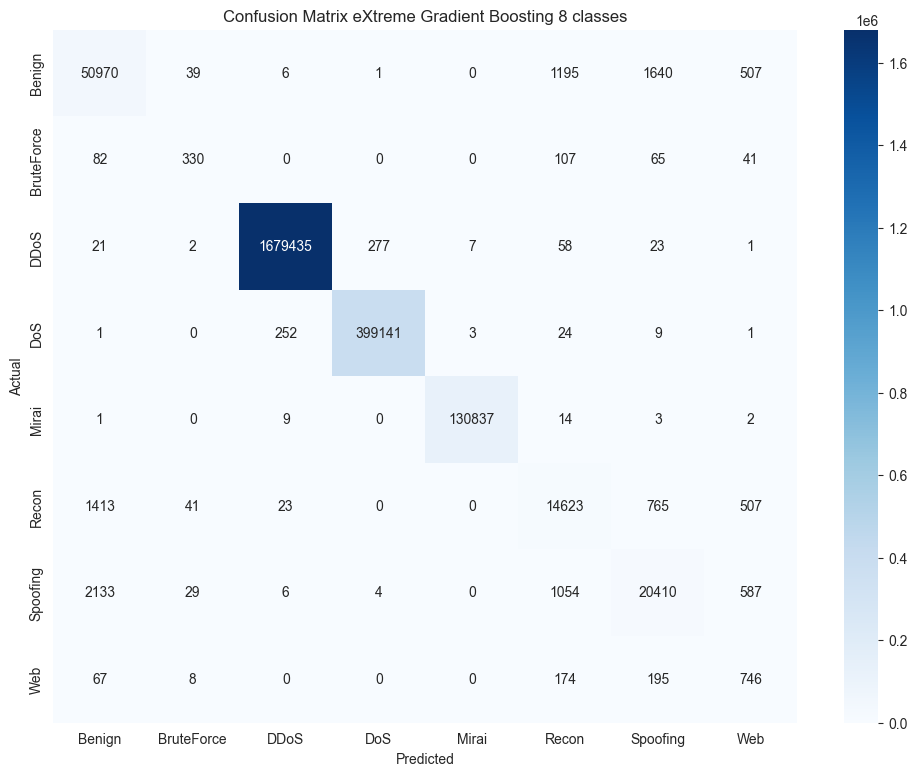

In [42]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
print("### 8 CLASSES; PREPROCESSED ###")
print("Model;accuracy;recall;precision;f1")
for k,v in preds.items():
    y_pred = v
    print(f"MACRO;{ML_neams[k]};{accuracy_score(y_pred, y_test)};{recall_score(y_pred, y_test, average='macro')};{precision_score(y_pred, y_test, average='macro')};{f1_score(y_pred, y_test, average='macro')}")
    print(f"WEIGHTED;{ML_neams[k]};{accuracy_score(y_pred, y_test)};{recall_score(y_pred, y_test, average='weighted')};{precision_score(y_pred, y_test, average='weighted')};{f1_score(y_pred, y_test, average='weighted')}")
    
    cm = confusion_matrix(y_test, y_pred)
    cn = ML_models[k].classes_
    if ML_neams[k] == ML_neams[-1]:
        cn = label_encoder.inverse_transform(ML_models[k].classes_)
    
    plt.figure(figsize=(12, 9))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cn, yticklabels=cn)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix {ML_neams[k]} 8 classes')
    plt.show()
    
    # Convert confusion matrix array to a DataFrame
    cm_df = pd.DataFrame(cm, index=cn, columns=cn)
    
    # Export the DataFrame to a CSV file
    cm_df.to_csv(f'cms-42-preprocessing-FIXED/confusion_matrix-{ML_neams[k]}-8.csv')

print('\n\n')

## Confusion matrix observations
Interesting patterns can be seen when looking at the confusion matrix here. Of course a lot of correct predictions can be seen regarding the DoS and DDoS attacks. Not much mistakes are between DoS and DDoS due to high counts of this data. However, for recon, spoofing, web attacks it can be seen a lot of them are confused between each other (and also sometimes with benign packets). This can be caused not only by the limited counts of data for these labels, but also because these attacks more resemble natural traffic characteristics compared to aggressive flooding of DDoS and DoS attacks.

# Classification: 2 (1+1) Classes

In [43]:
if True:
    dict_2classes = {}
    dict_2classes['DDoS-RSTFINFlood'] = 'Attack'
    dict_2classes['DDoS-PSHACK_Flood'] = 'Attack'
    dict_2classes['DDoS-SYN_Flood'] = 'Attack'
    dict_2classes['DDoS-UDP_Flood'] = 'Attack'
    dict_2classes['DDoS-TCP_Flood'] = 'Attack'
    dict_2classes['DDoS-ICMP_Flood'] = 'Attack'
    dict_2classes['DDoS-SynonymousIP_Flood'] = 'Attack'
    dict_2classes['DDoS-ACK_Fragmentation'] = 'Attack'
    dict_2classes['DDoS-UDP_Fragmentation'] = 'Attack'
    dict_2classes['DDoS-ICMP_Fragmentation'] = 'Attack'
    dict_2classes['DDoS-SlowLoris'] = 'Attack'
    dict_2classes['DDoS-HTTP_Flood'] = 'Attack'
    
    dict_2classes['DoS-UDP_Flood'] = 'Attack'
    dict_2classes['DoS-SYN_Flood'] = 'Attack'
    dict_2classes['DoS-TCP_Flood'] = 'Attack'
    dict_2classes['DoS-HTTP_Flood'] = 'Attack'
    
    
    dict_2classes['Mirai-greeth_flood'] = 'Attack'
    dict_2classes['Mirai-greip_flood'] = 'Attack'
    dict_2classes['Mirai-udpplain'] = 'Attack'
    
    dict_2classes['Recon-PingSweep'] = 'Attack'
    dict_2classes['Recon-OSScan'] = 'Attack'
    dict_2classes['Recon-PortScan'] = 'Attack'
    dict_2classes['VulnerabilityScan'] = 'Attack'
    dict_2classes['Recon-HostDiscovery'] = 'Attack'
    
    dict_2classes['DNS_Spoofing'] = 'Attack'
    dict_2classes['MITM-ArpSpoofing'] = 'Attack'
    
    dict_2classes['BenignTraffic'] = 'Benign'
    
    dict_2classes['BrowserHijacking'] = 'Attack'
    dict_2classes['Backdoor_Malware'] = 'Attack'
    dict_2classes['XSS'] = 'Attack'
    dict_2classes['Uploading_Attack'] = 'Attack'
    dict_2classes['SqlInjection'] = 'Attack'
    dict_2classes['CommandInjection'] = 'Attack'
    
    dict_2classes['DictionaryBruteForce'] = 'Attack'

## Training - 2 classes

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
ML_models = [ # or 'rbf', 'poly' for different kernels
        LogisticRegression(),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        xgb.XGBClassifier(
            n_estimators=100,
            max_depth=10,
            learning_rate=0.1,
            random_state=SEED,
            device='cuda'
        ),
        
]

ML_neams = [
        'LogisticRegresion',
        'Decision Tree',
        'Random Forest',
        'eXtreme Gradient Boosting'
]
for train_set in tqdm(training_sets):
    d = pd.read_csv(DATASET_DIRECTORY + train_set)
    # Undersample until there are no classes which have more samples than benign, and then apply SMOTE
    label_counts = Counter(d[y_column]).most_common()
    old_len = len(d[y_column])
    benign_index = next((i for i, l in enumerate(label_counts) if l[0] == 'BenignTraffic'))
    less_than_six_labels = [l[0] for i, l in enumerate(label_counts) if l[1] <= 5]
    resampling_pipeline = Pipeline([
        ('over', RandomOverSampler(sampling_strategy={l: 6 for l in less_than_six_labels}, random_state=42)),
        ('under', RandomUnderSampler(sampling_strategy={l[0]: label_counts[benign_index][1] for l in label_counts[:benign_index]}, random_state=42)),
        ('SMOTE', SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5))
    ])
    X, y = resampling_pipeline.fit_resample(d[X_columns], d[y_column])
    new_len = len(y)
    print(f"Old len: {old_len}; New len: {new_len}")
    del d
    
    new_y = [dict_2classes[k] for k in y]
    y = new_y
    X = scaler.fit_transform(X)
    for i, model in enumerate(ML_models):
        if i == len(ML_models)-1:
            y = label_encoder.fit_transform(y)
        model.fit(X, y)

  0%|          | 0/33 [00:00<?, ?it/s]

Old len: 238687; New len: 190400
Old len: 218805; New len: 176800
Old len: 275258; New len: 217158
Old len: 231023; New len: 180098
Old len: 227491; New len: 183124
Old len: 240046; New len: 196758
Old len: 227910; New len: 181118
Old len: 246327; New len: 199716
Old len: 227616; New len: 185776
Old len: 251392; New len: 203728
Old len: 221928; New len: 177514
Old len: 238476; New len: 185980
Old len: 238761; New len: 193120
Old len: 215838; New len: 171564
Old len: 268649; New len: 218518
Old len: 232885; New len: 183600
Old len: 223444; New len: 176766
Old len: 234430; New len: 187578
Old len: 231063; New len: 183498
Old len: 237151; New len: 186592
Old len: 223401; New len: 177242
Old len: 252212; New len: 204952
Old len: 262062; New len: 214608
Old len: 225725; New len: 174862
Old len: 447625; New len: 357850
Old len: 221014; New len: 179894
Old len: 251676; New len: 206074
Old len: 238350; New len: 195058
Old len: 228730; New len: 181730
Old len: 227636; New len: 185198
Old len: 4

### Testing - 2 classes

In [45]:
y_test = []
preds = {i:[] for i in range(len(ML_models))}
for test_set in tqdm(test_sets):
    d_test = pd.read_csv(DATASET_DIRECTORY + test_set)
    d_test[X_columns] = scaler.transform(d_test[X_columns])
    new_y = [dict_2classes[k] for k in d_test[y_column]]
    d_test[y_column] = new_y
    
    y_test += list(d_test[y_column].values)
    
    for i in range(len(ML_models)):
        model = ML_models[i]
        y_pred = list(model.predict(d_test[X_columns]))
        if i == len(ML_models)-1:
            y_pred = list(label_encoder.inverse_transform(model.predict(d_test[X_columns])))
        preds[i] = preds[i] + y_pred
        

  0%|          | 0/8 [00:00<?, ?it/s]

### Evaluation - 2 classes

### 2 CLASSES; PREPROCESSED ###
Model;accuracy;recall;precision;f1
MACRO;LogisticRegresion;0.9823834681823953;0.9521276560528827;0.6374884759836865;0.7076413617991435
WEIGHTED;LogisticRegresion;0.9823834681823953;0.9823834681823953;0.994334809789215;0.9870625951562335


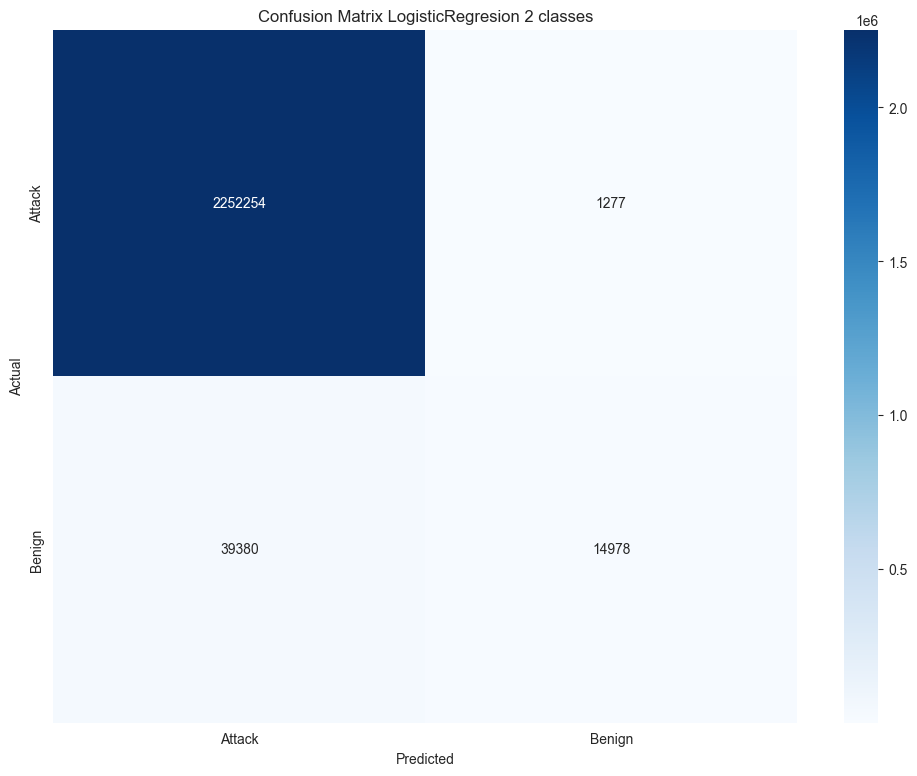

MACRO;Decision Tree;0.9952887682206554;0.9565112536644786;0.9394563710380072;0.9478129712977066
WEIGHTED;Decision Tree;0.9952887682206554;0.9952887682206554;0.9953943311333892;0.9953336073312175


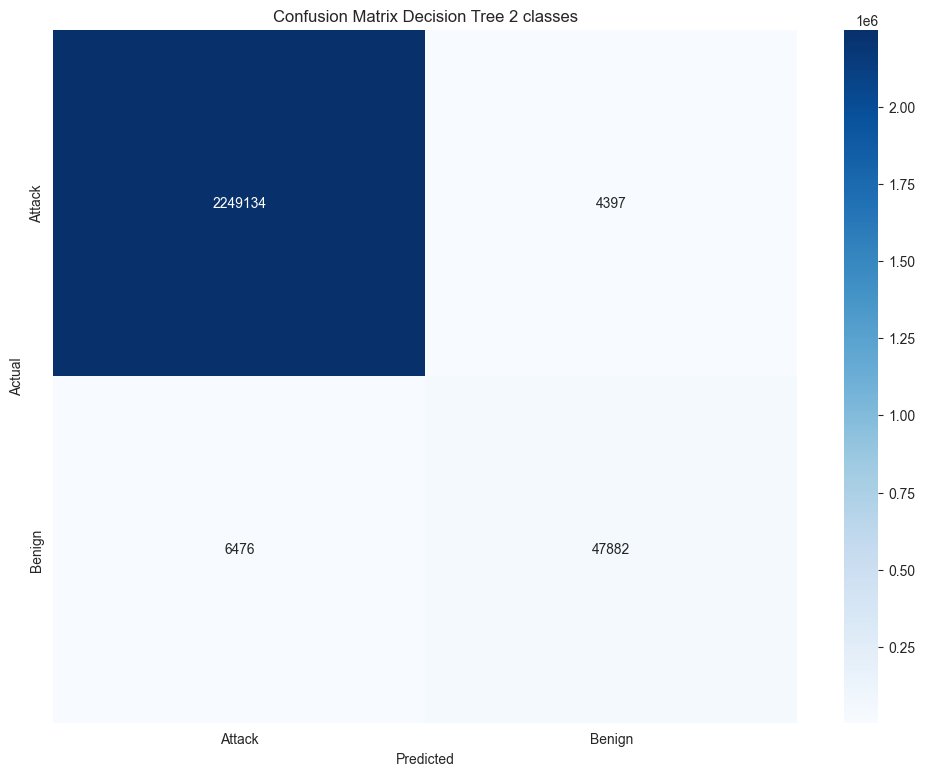

MACRO;Random Forest;0.9961687932131918;0.9764209032156823;0.9384887253481016;0.9566286486682876
WEIGHTED;Random Forest;0.9961687932131918;0.9961687932131918;0.9964009641068604;0.9962482108748243


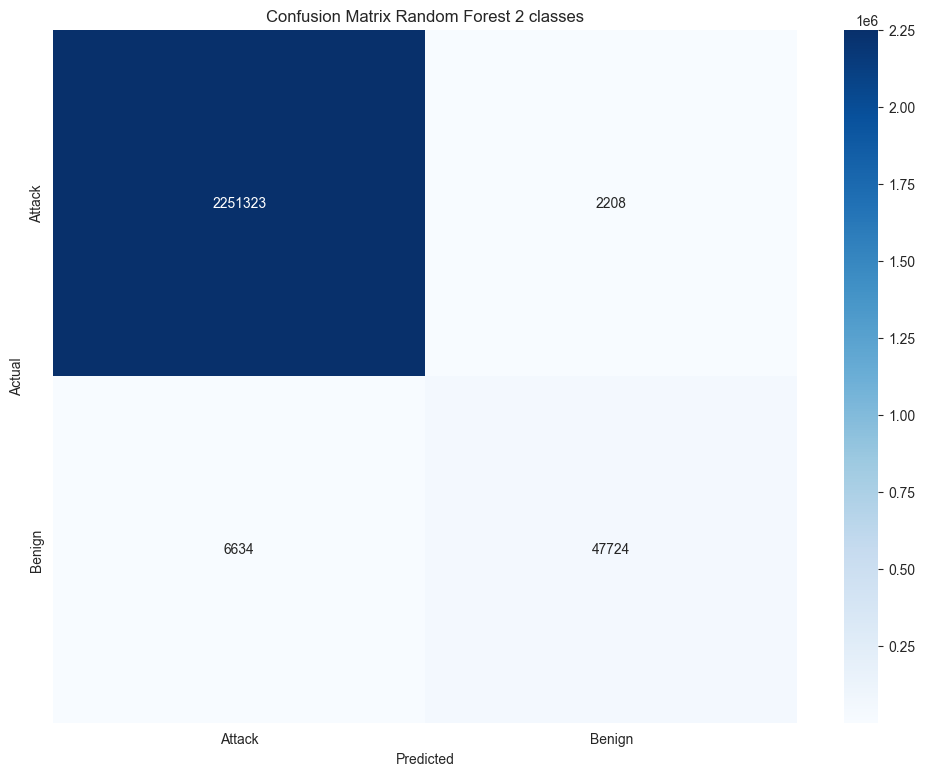

MACRO;eXtreme Gradient Boosting;0.9968789660161299;0.9691883402046042;0.9625231543713815;0.9658306647957513
WEIGHTED;eXtreme Gradient Boosting;0.9968789660161299;0.9968789660161299;0.9969036802582664;0.9968901294743798


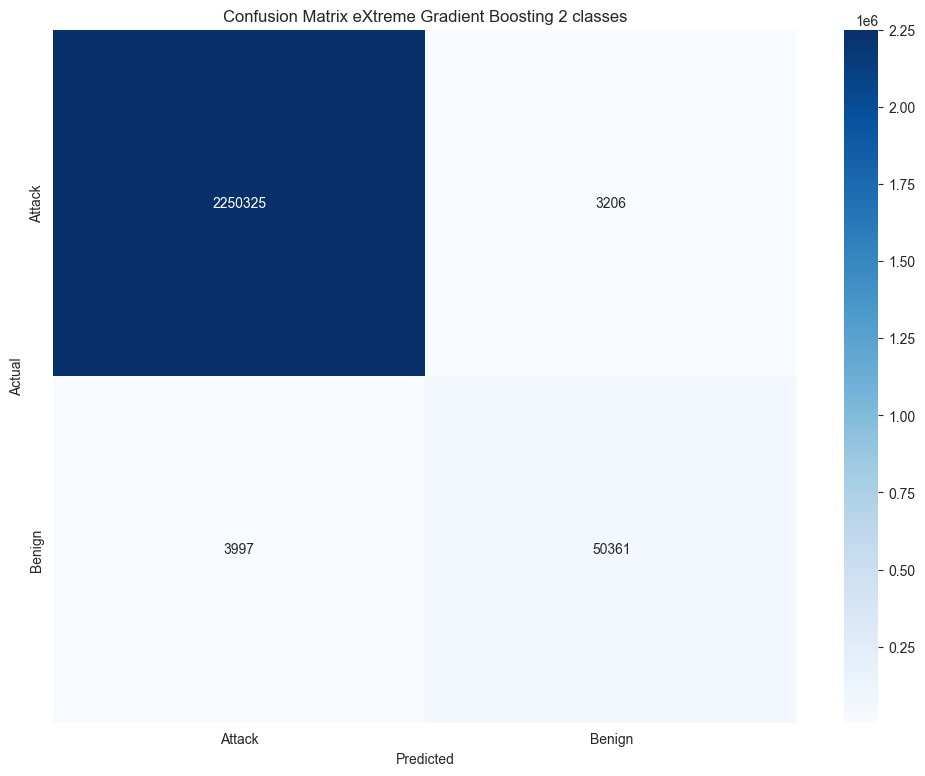

In [46]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
print("### 2 CLASSES; PREPROCESSED ###")
print("Model;accuracy;recall;precision;f1")
for k,v in preds.items():
    y_pred = v
    print(f"MACRO;{ML_neams[k]};{accuracy_score(y_pred, y_test)};{recall_score(y_pred, y_test, average='macro')};{precision_score(y_pred, y_test, average='macro')};{f1_score(y_pred, y_test, average='macro')}")
    print(f"WEIGHTED;{ML_neams[k]};{accuracy_score(y_pred, y_test)};{recall_score(y_pred, y_test, average='weighted')};{precision_score(y_pred, y_test, average='weighted')};{f1_score(y_pred, y_test, average='weighted')}")
    
    cm = confusion_matrix(y_test, y_pred)
    cn = ML_models[k].classes_
    if ML_neams[k] == ML_neams[-1]:
        cn = label_encoder.inverse_transform(ML_models[k].classes_)
    
    plt.figure(figsize=(12, 9))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cn, yticklabels=cn)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix {ML_neams[k]} 2 classes')
    plt.show()
    
    # Convert confusion matrix array to a DataFrame
    cm_df = pd.DataFrame(cm, index=cn, columns=cn)
    
    # Export the DataFrame to a CSV file
    cm_df.to_csv(f'cms-42-preprocessing-FIXED/confusion_matrix-{ML_neams[k]}-2.csv')

print('\n\n')

## Confusion matrix 2 classes
Recall and precision is balanced for all analysed algorithms apart from the logistic regression which interestingly has high accuracy but low recall. This can be seen on the matrix as a lot of benign packets being predicted as attack. This also shows susceptibility of logistic regresison to imbalanced sets

## ML algoritm evaluation - comparison
Below are shown tables comparing different ML algorithm performance for non-preprocessed data vs preprocessed data as described earlier in this notebook. Mainly the macro mode of metrics is considered.

#### 34 CLASSES
| Metric type | Model                     | Accuracy | Recall | Precision | F1    |
| ----------- | ------------------------- | -------- | ------ | --------- | ----- |
| MACRO       | LogisticRegresion         | 0,801    | 0,587  | 0,482     | 0,487 |
| WEIGHTED    | LogisticRegresion         | 0,801    | 0,801  | 0,912     | 0,836 |
| MACRO       | Decision Tree             | 0,993    | 0,819  | 0,832     | 0,824 |
| WEIGHTED    | Decision Tree             | 0,993    | 0,993  | 0,993     | 0,993 |
| MACRO       | Random Forest             | 0,992    | 0,851  | 0,718     | 0,729 |
| WEIGHTED    | Random Forest             | 0,992    | 0,992  | 0,994     | 0,993 |
| MACRO       | eXtreme Gradient Boosting | 0,992    | 0,794  | 0,726     | 0,740 |
| WEIGHTED    | eXtreme Gradient Boosting | 0,992    | 0,992  | 0,993     | 0,993 |
#### 34 CLASSES; PREPROCESSED
| Metric type | Model                     | Accuracy | Recall | Precision | F1    |
| ----------- | ------------------------- | -------- | ------ | --------- | ----- |
| MACRO       | LogisticRegresion         | 0,788    | 0,505  | 0,559     | 0,496 |
| WEIGHTED    | LogisticRegresion         | 0,788    | 0,788  | 0,828     | 0,798 |
| MACRO       | Decision Tree             | 0,991    | 0,771  | 0,831     | 0,794 |
| WEIGHTED    | Decision Tree             | 0,991    | 0,991  | 0,990     | 0,990 |
| MACRO       | Random Forest             | 0,991    | 0,759  | 0,767     | 0,759 |
| WEIGHTED    | Random Forest             | 0,991    | 0,991  | 0,991     | 0,991 |
| MACRO       | eXtreme Gradient Boosting | 0,994    | 0,835  | 0,827     | 0,829 |
| WEIGHTED    | eXtreme Gradient Boosting | 0,994    | 0,994  | 0,994     | 0,994 |

For 34 classes, the preprocessed version is slightly better when comparing macro f1 score. eXtreme Gradient Boosting for preprocessed has f1 = 0.829 where for no preprocessing the best is Decision Tree at f1 = 0.824. However, the difference is not significant
#### 8 CLASSES
| Metric type | Model                     | Accuracy | Recall | Precision | F1    |
| ----------- | ------------------------- | -------- | ------ | --------- | ----- |
| MACRO       | LogisticRegresion         | 0,831    | 0,758  | 0,512     | 0,540 |
| WEIGHTED    | LogisticRegresion         | 0,831    | 0,831  | 0,952     | 0,878 |
| MACRO       | Decision Tree             | 0,994    | 0,822  | 0,837     | 0,828 |
| WEIGHTED    | Decision Tree             | 0,994    | 0,994  | 0,994     | 0,994 |
| MACRO       | Random Forest             | 0,995    | 0,934  | 0,716     | 0,735 |
| WEIGHTED    | Random Forest             | 0,995    | 0,995  | 0,996     | 0,995 |
| MACRO       | eXtreme Gradient Boosting | 0,995    | 0,838  | 0,730     | 0,752 |
| WEIGHTED    | eXtreme Gradient Boosting | 0,995    | 0,995  | 0,995     | 0,995 |
#### 8 CLASSES; PREPROCESSED
| Metric type | Model                     | Accuracy | Recall | Precision | F1    |
| ----------- | ------------------------- | -------- | ------ | --------- | ----- |
| MACRO       | LogisticRegresion         | 0,809    | 0,561  | 0,545     | 0,490 |
| WEIGHTED    | LogisticRegresion         | 0,809    | 0,809  | 0,893     | 0,837 |
| MACRO       | Decision Tree             | 0,994    | 0,780  | 0,840     | 0,803 |
| WEIGHTED    | Decision Tree             | 0,994    | 0,994  | 0,993     | 0,993 |
| MACRO       | Random Forest             | 0,994    | 0,819  | 0,780     | 0,784 |
| WEIGHTED    | Random Forest             | 0,994    | 0,994  | 0,994     | 0,994 |
| MACRO       | eXtreme Gradient Boosting | 0,995    | 0,839  | 0,847     | 0,834 |
| WEIGHTED    | eXtreme Gradient Boosting | 0,995    | 0,995  | 0,995     | 0,995 |

For 8 classes the improvement is slightly better. Again for preprocessed version eXtreme Gradient Boost is better by similar amount as in 8 classes. It is worth noting again that Decision Tree is better for raw data rather than preprocessed, giving very good results compared to other solutions
#### 2 CLASSES
| Metric type | Model                     | Accuracy | Recall | Precision | F1    |
| ----------- | ------------------------- | -------- | ------ | --------- | ----- |
| MACRO       | LogisticRegresion         | 0,989    | 0,891  | 0,864     | 0,877 |
| WEIGHTED    | LogisticRegresion         | 0,989    | 0,989  | 0,990     | 0,989 |
| MACRO       | Decision Tree             | 0,996    | 0,956  | 0,957     | 0,956 |
| WEIGHTED    | Decision Tree             | 0,996    | 0,996  | 0,996     | 0,996 |
| MACRO       | Random Forest             | 0,997    | 0,965  | 0,971     | 0,968 |
| WEIGHTED    | Random Forest             | 0,997    | 0,997  | 0,997     | 0,997 |
| MACRO       | eXtreme Gradient Boosting | 0,997    | 0,959  | 0,973     | 0,966 |
| WEIGHTED    | eXtreme Gradient Boosting | 0,997    | 0,997  | 0,997     | 0,997 |
#### 2 CLASSES; PREPROCESSED
| Metric type | Model                     | Accuracy | Recall | Precision | F1    |
| ----------- | ------------------------- | -------- | ------ | --------- | ----- |
| MACRO       | LogisticRegresion         | 0,982    | 0,952  | 0,637     | 0,708 |
| WEIGHTED    | LogisticRegresion         | 0,982    | 0,982  | 0,994     | 0,987 |
| MACRO       | Decision Tree             | 0,995    | 0,957  | 0,939     | 0,948 |
| WEIGHTED    | Decision Tree             | 0,995    | 0,995  | 0,995     | 0,995 |
| MACRO       | Random Forest             | 0,996    | 0,976  | 0,938     | 0,957 |
| WEIGHTED    | Random Forest             | 0,996    | 0,996  | 0,996     | 0,996 |
| MACRO       | eXtreme Gradient Boosting | 0,997    | 0,969  | 0,963     | 0,966 |
| WEIGHTED    | eXtreme Gradient Boosting | 0,997    | 0,997  | 0,997     | 0,997 |

The results for 2 classes are roughly the same for both dataset scenarios, slighly leaning towards better results for non-processed data. This means that the chosen method of preprocessing is good only for non-binary classification in this dataset


# Conclusions
The analysis shows that the application of ML for packet analysis can be a good enhancement to existing systems. The applied preprocessing overall helped and resulted in significant improvements for the eXtreme Gradient Boosting, but the imbalanced data still proved a challenge for the algorithms. SMOTE and artifical upsampling is not fully equivalent to real data, hence the results are not perfect despite applying preprocessing techniques.

The results for dataset that was not preprocessed are still good. Decision tree and random forest algorithms still perform well and sometimes even better than the equivalents for the same class counts e.g. for 34 classes decision tree/random forest is better in macro F1 score than eXtreme Gradient Boosting for preprocessed variant. 

Classical ML algorithms performed better than ANN. This is possible given that the problem was classification. ANNs are more suited for advanced data or image processing. However, more complicated ANN design, hyperparameter tuning and further data preprocessing could possibly make an ANN better than other solutions


# Attachments
[neural_pytorch.ipynb](neural_pytorch.ipynb) - pytorch implementation of a simple ANN for the CICIoT2023 dataset\
[seed42.ipynb](example_seed42.ipynb) - variant of this notebook without SMOTE and under-sampling techniques\
[IoT attack classification.pdf](IoT%20attack%20classification.pdf) - presentation\
[model_comparison.xlsx](model_comparison.xlsx) - tables comparing models in Excel format

# References
https://www.unb.ca/cic/datasets/iotdataset-2023.html \
https://xgboost.readthedocs.io/en/stable/python/sklearn_estimator.html \
https://imbalanced-learn.org/stable/references/index.html#api \
https://www.kaggle.com/code/madhavmalhotra/feature-exploration-on-ciciot2023
